# Gaussian processes intro

### GPs intuition

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

### Gaussian Processes

A thorough introduction to Gaussian Processes is obviously not in scope of this notebook. To find out more, we recomment reading chapters 2, 4 and 5 of Gaussian Processes for Machine Learning.

**What are Gaussian Processes?**
A Gaussian Process is a collection of random variables, each finite subset of which follows a joint multivariate normal distribution. Let $X$ be a set that indexes the collection of random veriables, and let $f(x)$ be the associated random variables. For the remainder of this notebook, we'll assume $X = \mathrm{R}$. For any two reals $x$, $x'$ the mean function and covariance functions are defined to be $$ m(x) = \mathrm{E}(f(x)) $$ and $$ k(x, x') = \mathrm{E}(f(x) - m(x))(f(x') - m(x')). $$ These two functions entirely determine the Gaussian process, and we write $$ f(x) \sim \mathcal{GP}(m, k). $$

We can view the Gaussian process as a probability distribution over the functions from $\mathrm{R}$ to $\mathrm{R}$, in the sense that any draw of $f(x)$ at a finite number of points $x_1$, $x_2$, $\ldots$ represents a draw from our distribution over functions evaluated at this finite number of points. Thus mean and covariance functions are a way of implicitly defining a probability distribution over functions from $\mathrm{R}$ to $\mathrm{R}$; $m$ represents the average function and $k$ represents how much we expect functions deviate from it, both in terms of the value they take at $x$ (because $k(x, x) = \mathrm{Var}(f(x))$) and the value they take at $x$ in relation to the value they take at other values $x'$ (because $k(x, x') = \mathrm{Cov}(f(x), f(x'))$. For example, say $m(x) = 0$ and $k$, is defined by $$ k(x, x') = \mathrm{exp}(-(x - x')^2 / 2) $$ Then functions for which $f(x)$ differs significantly from $f(x')$ when $|x - x'| \ll 1$ are not likely under the probability distribution over functions defined by $k$.

**How do we perform predictions using Gaussian processes?**
As explained above, a Gaussian process defines a distribution over functions. In the Bayesian setting, this will represent a prior belief over the functional form that links predictors $x_1$, $x_2$, $\ldots$ and observed values points $y_1$, $y_2$, $\ldots$. As is usual, we do not assume that we observe $f(x)$ direclty, but rather that we observe $f(x)$ with some normal iid noise, i.e. $y_i$ is a sample from $N(f(x_i), \sigma_{\text{noise}}^2)$.

Therefore, if we denote by $\mathbf{y}$ the vector of random observed values, the joint distribution of $\mathbf{y}$ and $f(x)$ (the Gaussian process at a point $x$ where we would like to make a prediction) is

$$ \begin{pmatrix} \mathbf{y} \ f(x) \end{pmatrix} \sim N(0, \begin{pmatrix} K(X, X) + \sigma_{\text{noise}}^2 I& K(X, x) \ K(x, X) & k(x, x) \end{pmatrix} $$

To compute our posterior belief on the distribution of $f(x)$, we condition on $\mathbf{y}$ being equal to the observed values $y_1$, $y_2$, $\ldots$. The conditional distribution is $$ p(f(x) | y) \sim \mathrm{N}\left(\mathbf{\mu}, \mathbf{\Sigma}\right) $$ where $$ \mathbf{\mu} = K(X^,X)K(X,X)^{-1}y, $$ $$ \mathbf{\Sigma} = K(X^, X^) - K(X^,X)K(X,X)^{-1}K(X, X^*) $$ where for two vectors $A$, $B$, $K(A,B)$ is the matrix whose $(i, j)$th entry is $k(A_i, B_i)$. (See Conditional distribution of a multivariate normal)

Now, in practice, we seldom specify a kernel fully - rather, we parameterise the kernel and specify priors distributions for the kernel parameters, compute posterior values for the kernel parameters and then perform predictions (See "Fitting a Gaussian process" below).

**What are commonly used kernels?**
The most commonly used kernel is the squared exponential kernel with lenght scale $l$.

Dot product kernel - equivalent to performing Bayesian linear regression. Use if you suspect a linerar relationship between x and y.

The Squared Exponential Sine kernel with decay. Useful to model periodic functions.

Polynomial kernel.

Can create new kernels from old - see ... for full list of ways in which kernels can be added - we'll use two:

Adding two kernels
Multiplying by a constant
What is meant by fitting a Gaussian process?

# Multivariate Normals

In [2]:
# from bayesian_workflow.plotting import spaghetti_plot, ribbon_plot

In [3]:
# take from https://gist.github.com/omarfsosa/22e5a7c70cef03ad0c623c8197ee9c5c
def spaghetti_plot(
    x, y, n_samples=20, indices=None, ax=None, plot_kwargs=None
):
    """
    Plots x against a few picked examples of y.

    Parameters
    ----------
    x: 1d array
        The values for the x axis
    y: 2d array.
        First axis (0) is the samples axis.
        Second axis (1) are the values for the y axis.
    n_samples: int (default 20)
        How many sampled values to plot. `n_samples` are
        selected uniformly at random.
    indices: 1d array
        Indices of the specific samples that will be selected
        for plotting.
    ax: matplotlib.Axes
        The axes where the figure will be plotted.
    plot_kwargs: dict
        Extra arguments passed to `plt.plot`

    Returns
    -------
    matplotlib.Axes

    """
    has_indices = indices is not None
    has_samples = bool(n_samples)
    if has_indices == has_samples:
        _msg = "Exactly one of `n_samples` or `indices` must be specified"
        raise ValueError(_msg)

    if has_samples:
        indices = np.random.choice(range(y.shape[1]), n_samples)

    ax = ax or plt.gca()
    for idx in indices:
        ax.plot(x, y[idx], **(plot_kwargs or {}))

    return ax


def ribbon_plot(
    x,
    y,
    n_ribbons=10,
    percentile_min=1,
    percentile_max=99,
    ribbon_color="r",
    plot_median=True,
    line_color="k",
    ax=None,
    fill_kwargs=None,
    line_kwargs=None,
):
    """
    Make a ribbon plot that shows the different quantiles of the
    distribution of y against x.

    Parameters
    ----------
    x: 1d array
        The values for the x axis
    y: 2d array
    n_ribbons: int (default 10)
        How many quantiles to show
    percentile_min: float, between 0 and 50
        The lowest percentile to be shown
    percentile_max: float between 50 and 100
        The highest percentile to show.
    ribbon_color: str (default 'r')
        Color for the ribbons. Must be a valid expression for
        matplotlib colors.
    plot_median: bool (default True)
        Whether or not to plot a line for the 50% percentile
    line_color: str (default 'k')
        Color to use for the median.
    ax: matplotlib.Axes
        Where to plot the figure.
    fill_kwargs: dict
        Extra arguments passed to `plt.fill_between`.
        Controls the aspect of the ribbons.
    line_kwargs: dict
        Extra arguments to be passed to `plt.plot`.
        Controls the aspect of the median line.

    Returns
    -------
    matplotlib.Axes
    """
    perc1 = np.percentile(
        y,
        np.linspace(percentile_min, 50, num=n_ribbons, endpoint=False),
        axis=0,
    )
    perc2 = np.percentile(
        y, np.linspace(50, percentile_max, num=n_ribbons + 1)[1:], axis=0
    )
    fill_kwargs = fill_kwargs or {}
    line_kwargs = line_kwargs or {}
    alpha = fill_kwargs.pop("alpha", 1 / n_ribbons)
    ax = ax or plt.gca()
    plt.sca(ax)

    # fill ribbons
    for p1, p2 in zip(perc1, perc2):
        plt.fill_between(
            x, p1, p2, alpha=alpha, color=ribbon_color, **(fill_kwargs or {})
        )

    if plot_median:
        plot_func = plt.step if fill_kwargs.pop("step", None) else plt.plot
        plot_func(
            x, np.median(y, axis=0), color=line_color, **(line_kwargs or {})
        )

    return plt.gca()

In [4]:
corr = .9
stdev = 1
cov_matrix = np.array([
    [stdev ** 2, corr * stdev ** 2],
    [corr * stdev ** 2, stdev ** 2]
])
mean = np.array([0, 0])

In [5]:
num_samples = 1000
samples = st.multivariate_normal(cov=cov_matrix).rvs(num_samples)

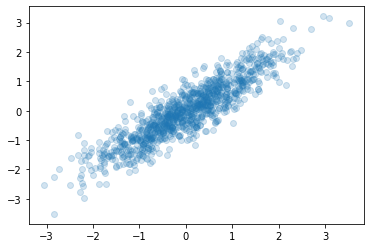

In [6]:
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.2)
# plt.xlim([-2, 2])
# plt.ylim([-2, 2])
plt.show()

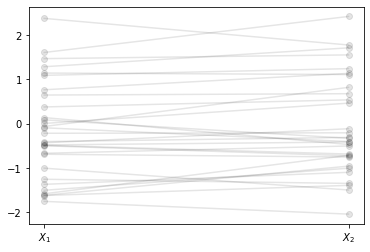

In [7]:
num_points = 30
plt.plot(samples[:num_points].T, marker='o', alpha=0.1, color='k');
plt.xticks([0, 1], ["$X_1$", "$X_2$"])
plt.show()

In [8]:
y0 = 1.5

# conditional mean of y1 given y0
m10 = mean[1] + cov_matrix[1, 0] * (y0 - mean[0]) / cov_matrix[0, 0]

# conditional variance of y1 given y0
s10 = cov_matrix[1, 1] - cov_matrix[1, 0] * cov_matrix[0, 1] / cov_matrix[0, 0]

# conditional density is a normal distribution
p10 = st.norm(loc=m10, scale=np.sqrt(s10)).rvs(num_points)

(-2.0, 3.0)

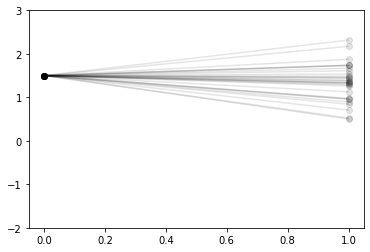

In [9]:
for y1 in p10:
    plt.plot([0, 1], [y0, y1], marker='o', color='k', alpha=0.1)
plt.ylim([-2, 3])

## Visualizing a multi-normal

In [10]:
num_dims = 100
var, length = .1, 50
X = np.arange(num_dims)

# construct a covariance matrix, on which the correlation between
# points decays exponentially with the distance between the points
ΔX = X[:, None] - X
ΔΧsq = np.power(ΔX / length, 2.0)
cov = var * np.exp(-0.5 * ΔΧsq)
eps = np.eye(cov.shape[0]) * 1e-5

In [11]:
num_samples = 10_000
samples = st.multivariate_normal(cov=cov + eps).rvs(num_samples)

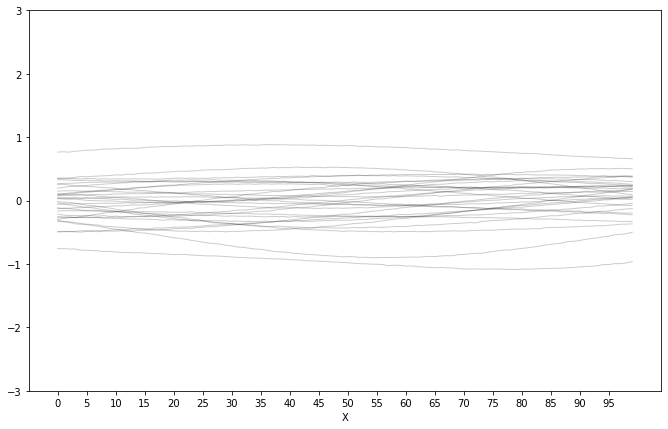

In [12]:
num_obs = 30
plt.figure(figsize=(7 * 1.618, 7))
plt.plot(samples[:num_obs].T, color='k', lw=1, marker='', alpha=0.2);
# plt.plot(samples[:num_obs].T, color='k', lw=1, marker='o', alpha=0.2);

plt.xlabel("X")
plt.xticks(range(num_dims)[::5])
# plt.xticks(range(num_dims))
plt.ylim([-3, 3])
plt.show()

In [13]:
x_observed = 30
y_observed = 0.5
conditioned = np.isclose(samples[:, x_observed], y_observed, atol=0.005)
conditioned.mean()

0.0027

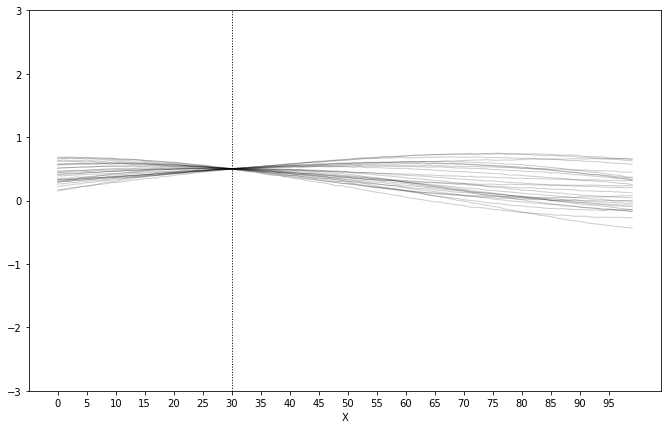

In [14]:
num_obs = 10
plt.figure(figsize=(7 * 1.618, 7))
plt.plot(samples[conditioned].T, color='k', lw=1, marker='', alpha=0.2);
# plt.plot(samples[conditioned].T, color='k', lw=1, marker='o', alpha=0.2);
plt.xlabel("X")
plt.xticks(range(num_dims)[::5])
# plt.xticks(range(num_dims))
plt.ylim([-3, 3])
plt.axvline(x=x_observed, linestyle=':', lw=1, color='k')
plt.show()

# Fitting a Gaussian process 

In [15]:
import os
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

from jax import random
from numpyro import sample, deterministic, plate
from numpyro.infer import MCMC, NUTS, Predictive

NUM_CPUS = int(os.environ.get("NUM_CPUS", os.cpu_count()))
numpyro.set_host_device_count(NUM_CPUS)
numpyro.enable_x64()

# set a random seed
rng_key = random.PRNGKey(42)


In [16]:
def squared_exponential_kernel(x1, x2, alpha, length, noise=True):
    dxsq = ((x1[:, None] - x2) / length) ** 2
    cov = (alpha ** 2) * jnp.exp(-0.5 * dxsq)
    if noise:
        return cov + 1e-8 * jnp.eye(cov.shape[0])
    
    return cov


In [17]:
class GPRegressor: # A class for using a GP for prediction given parameters
    def __init__(self, kernel, X, y, noise):
        self.kernel = kernel
        self.X = X
        self.y = y
        self.k_XX = self.kernel(self.X, self.X) + noise ** 2 * jnp.eye(self.X.shape[0])
        self.k_XX_inv = jnp.linalg.inv(self.k_XX) 
    def infer(self, x):
        k_xX = self.kernel(x, self.X, noise=False)
        k_Xx = self.kernel(self.X, x, noise=False)
        k_xx = self.kernel(x, x, noise=True)
        mean = k_Xx.T @ self.k_XX_inv @ self.y
        var = k_xx - k_xX @ self.k_XX_inv @ k_Xx
        return mean, var

In [18]:
def model(X, y):
    noise = numpyro.sample("noise", dist.Gamma(2, 2))
    length = numpyro.sample("length", dist.LogNormal(0, 1))
    var = numpyro.sample("var", dist.Gamma(2, 2))
    
    kernel = squared_exponential_kernel(X, X, var, length,)
    k_XX = kernel + noise * jnp.eye(X.shape[0])
    return numpyro.sample(
        "Y",
        dist.MultivariateNormal(
            loc=jnp.zeros(X.shape[0]),
            covariance_matrix=k_XX
        ),
        obs=y
    )


In [21]:
rng_key, key_x, key_y = random.split(rng_key, 3)
b0 = .5
b1 = -.2

sig = 0.2
x = random.uniform(key_x, shape=(50,), minval=-1, maxval=1)
x = jnp.sort(x)
y = b0 + b1 * x + 2 * jnp.sin(2 * jnp.pi * x) + sig * random.normal(key_y, shape=(50,))

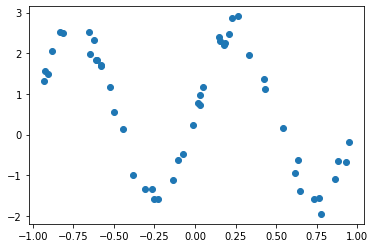

In [22]:
plt.plot(x, y, marker='o', lw=0)


In [23]:
nuts_kernel = NUTS(model)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=4,
)
mcmc.run(random.PRNGKey(1), x, y)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [24]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    length      0.28      0.05      0.28      0.20      0.37   1664.43      1.00
     noise      0.05      0.01      0.04      0.03      0.06   2198.65      1.00
       var      2.02      0.66      1.89      1.07      2.94   1467.23      1.00

Number of divergences: 0


In [25]:
def predict(rng_key, X, Y, X_test, var, length, noise):
    kernel = lambda x1, x2: squared_exponential_kernel(x1, x2, var, length, False)
    k_pp = kernel(X_test, X_test) + noise * jnp.eye(X_test.shape[0])
    k_pX = kernel(X_test, X) # no noise?
    k_XX = kernel(X, X) + noise * jnp.eye(X.shape[0])
    # compute kernels between train and test data, etc.
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * random.normal(
        rng_key, X_test.shape[:1]
    )
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise

In [26]:
x_test = jnp.linspace(-1.2, 1.2, num=200)

In [27]:
# do prediction
vmap_args = (
    random.split(rng_key, mcmc.get_samples()["var"].shape[0]),
    mcmc.get_samples()["var"],
    mcmc.get_samples()["length"],
    mcmc.get_samples()["noise"],
)
means, predictions = jax.vmap(
    lambda rng_key, var, length, noise: predict(
        rng_key, x, y, x_test, var, length, noise
    )
)(*vmap_args)

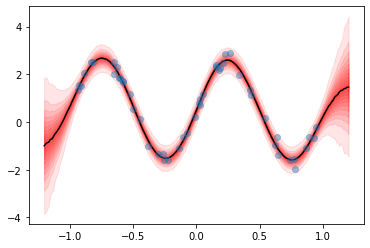

In [28]:
ribbon_plot(x_test, predictions)
plt.plot(x, y, marker='o', lw=0, alpha=0.4)